<a href="https://colab.research.google.com/github/ariizz/Aadhaar-Insight-Engine/blob/main/notebooks/data_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import glob
import os

In [2]:
def load_and_merge(folder_path):
    # Adjust path if folders are inside another directory
    files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not files:
        # Try searching one level deeper if folders were nested during unzip
        files = glob.glob(os.path.join(folder_path, "**/*.csv"), recursive=True)

    df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
    # Standardize date format
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    # Clean string data to avoid "Delhi" vs " delhi" issues
    df['state'] = df['state'].str.strip().str.title()
    df['district'] = df['district'].str.strip().str.title()
    return df

In [3]:
# Load the three master datasets
df_enrolment = load_and_merge('api_data_aadhar_enrolment')
df_demographic = load_and_merge('api_data_aadhar_demographic')
df_biometric = load_and_merge('api_data_aadhar_biometric')

print(f"Enrolment Rows: {len(df_enrolment)}")
print(f"Demographic Rows: {len(df_demographic)}")
print(f"Biometric Rows: {len(df_biometric)}")

Enrolment Rows: 1006029
Demographic Rows: 1642109
Biometric Rows: 1861108


#The "Biometric Lag" Metric (Feature Engineering)
---
In Aadhaar policy, children must update biometrics at age 5 and 15. This is called a Mandatory Biometric Update (MBU).

<i>The Problem: Many parents do demographic updates (change address/name) but skip the biometric update because it requires the child to be present.

<i>The Hack: Creating a "Compliance Score" by comparing bio_age_5_17 to demo_age_5_17.

In [4]:
# Aggregate by district
dist_bio = df_biometric.groupby(['state', 'district'])['bio_age_5_17'].sum()
dist_demo = df_demographic.groupby(['state', 'district'])['demo_age_5_17'].sum()

# Calculate the Lag Ratio
compliance_df = pd.concat([dist_bio, dist_demo], axis=1)
compliance_df['lag_ratio'] = compliance_df['bio_age_5_17'] / compliance_df['demo_age_5_17']

# Districts where lag_ratio is < 0.5 are "High Priority" (Updates are happening, but biometrics are being ignored)
priority_districts = compliance_df[compliance_df['lag_ratio'] < 0.5].sort_values('lag_ratio')

In [5]:
# 1. Aggregate totals for Growth (New Enrolments) and Maintenance (Updates)
e_agg = df_enrolment.groupby(['state', 'district']).agg({'age_0_5':'sum', 'age_5_17':'sum', 'age_18_greater':'sum'}).reset_index()
d_agg = df_demographic.groupby(['state', 'district']).agg({'demo_age_5_17':'sum', 'demo_age_17_':'sum'}).reset_index()
b_agg = df_biometric.groupby(['state', 'district']).agg({'bio_age_5_17':'sum', 'bio_age_17_':'sum'}).reset_index()

# 2. Merge all into one Master District Table
df_master = e_agg.merge(d_agg, on=['state', 'district'], how='outer').merge(b_agg, on=['state', 'district'], how='outer').fillna(0)

# 3. Calculate Key Metrics
df_master['Growth'] = df_master['age_0_5'] + df_master['age_5_17'] + df_master['age_18_greater']
df_master['Maintenance'] = df_master['demo_age_5_17'] + df_master['demo_age_17_'] + df_master['bio_age_5_17'] + df_master['bio_age_17_']
df_master['Efficiency_Score'] = df_master['Maintenance'] / df_master['Growth']

# 4. Segment Districts
growth_median = df_master['Growth'].median()
maint_median = df_master['Maintenance'].median()

def segment_district(row):
    if row['Growth'] > growth_median and row['Maintenance'] > maint_median:
        return 'High Activity Hub'
    if row['Growth'] > growth_median and row['Maintenance'] <= maint_median:
        return 'Growth Phase (New Users)'
    if row['Growth'] <= growth_median and row['Maintenance'] > maint_median:
        return 'Saturated (Update Heavy)'
    return 'Inactive/Dark Zone'

df_master['Segment'] = df_master.apply(segment_district, axis=1)
print(df_master['Segment'].value_counts())

Segment
Inactive/Dark Zone          490
High Activity Hub           489
Saturated (Update Heavy)     56
Growth Phase (New Users)     56
Name: count, dtype: int64


In [6]:
import plotly.express as px

fig = px.scatter(df_master,
                 x="Growth",
                 y="Maintenance",
                 color="Segment",
                 hover_name="district",
                 log_x=True, log_y=True,
                 title="Aadhaar Lifecycle: Growth vs Maintenance by District",
                 labels={'Growth': 'New Enrolments (Log Scale)', 'Maintenance': 'Total Updates (Log Scale)'})

fig.add_hline(y=maint_median, line_dash="dot", annotation_text="Maintenance Median")
fig.add_vline(x=growth_median, line_dash="dot", annotation_text="Growth Median")

fig.show()

#The "Zero-to-Five" Saturation Gap
---
<i>The Insight: Aadhaar is almost universal for adults, so the "Future of Enrolment" is newborns.
<i>The Goal: Finding districts that are failing to register babies (Age 0-5) despite being "High Activity" hubs.

In [7]:
# Aggregate Enrolment specifically for toddlers
infant_enrol = df_enrolment.groupby(['state', 'district'])['age_0_5'].sum().reset_index()

# Plot Top 10 States with highest newborn registration
fig1 = px.bar(infant_enrol.groupby('state')['age_0_5'].sum().sort_values(ascending=False).head(10),
             title="The Next Generation: Top 10 States by Infant Enrolment (Age 0-5)",
             labels={'value': 'Total Enrolments', 'state': 'State'},
             color_continuous_scale='Viridis')
fig1.show()

#The "Update Fatigue" Trend (Time-Series)
---
<i>The Insight: People update their Aadhaar in bursts (usually when schools open or subsidy deadlines approach).
<i>The Goal: Identifying the "Seasonal Peaks" so the government knows when to staff more people at centers.

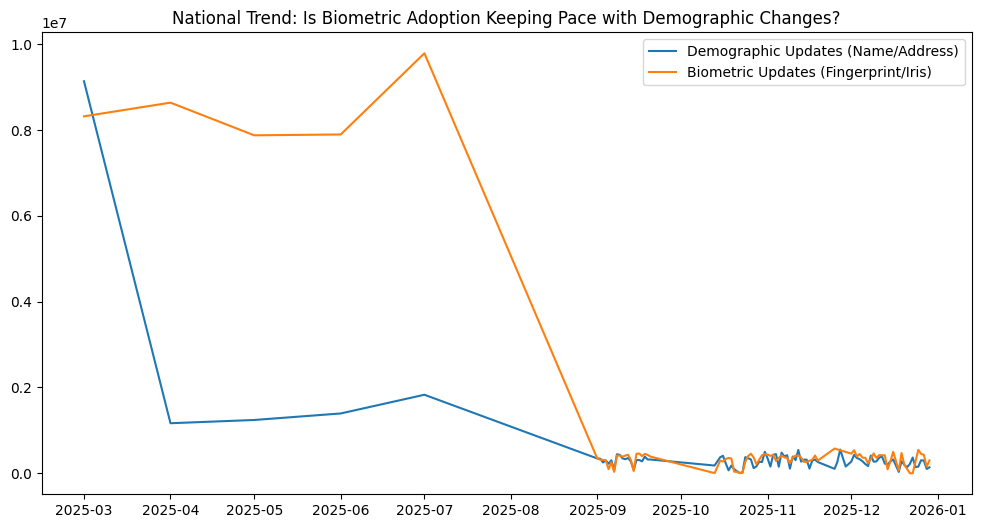

In [8]:
# Combine all updates (Demographic + Biometric) by Date
df_demographic['total_demo'] = df_demographic['demo_age_5_17'] + df_demographic['demo_age_17_']
df_biometric['total_bio'] = df_biometric['bio_age_5_17'] + df_biometric['bio_age_17_']

demo_trend = df_demographic.groupby('date')['total_demo'].sum()
bio_trend = df_biometric.groupby('date')['total_bio'].sum()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(demo_trend, label="Demographic Updates (Name/Address)")
plt.plot(bio_trend, label="Biometric Updates (Fingerprint/Iris)")
plt.title("National Trend: Is Biometric Adoption Keeping Pace with Demographic Changes?")
plt.legend()
plt.show()

###<b>If Demographic updates are much higher than Biometric, people are changing addresses but not updating security features—a major security risk.

#Regional "Dark Zones" (Pincode Analysis)
---
<i>The Insight: A district might look "Good" on average, but certain Pincodes might have zero activity. These are "Service Deserts."
<i>The Goal: Listing the specific Pincodes that need a Mobile Aadhaar Van.

In [9]:
# Identify Pincodes with very low activity across all 3 datasets
pincode_activity = df_enrolment.groupby('pincode').size().reset_index(name='enrol_count')
# Filter for pincodes with less than 5 records in the entire duration
service_deserts = pincode_activity[pincode_activity['enrol_count'] < 5].merge(
    df_enrolment[['pincode', 'state', 'district']], on='pincode', how='left'
).drop_duplicates()

print("Top 10 Service Deserts (Priority for Mobile Vans):")
print(service_deserts.head(10))

Top 10 Service Deserts (Priority for Mobile Vans):
    pincode  enrol_count    state   district
0    121014            4  Haryana  Faridabad
4    122098            4  Haryana    Gurgaon
8    134101            3  Haryana  Panchkula
11   141004            4   Punjab   Ludhiana
15   141106            4   Punjab   Ludhiana
19   142028            4   Punjab   Ludhiana
23   143005            3   Punjab   Amritsar
26   143026            4   Punjab   Amritsar
30   144011            2   Punjab  Jalandhar
32   144028            3   Punjab  Jalandhar


#The "Efficiency" Metric: Updates vs. New Enrolments
---
<i>The Insight: In a mature state (like Kerala or Delhi), 90% of activity should be Updates. In a developing state (like Bihar or UP), activity should be New Enrolments.

<i>The Goal: Categorizing states to tell the government what to build.

In [10]:
# Calculate Ratio
state_enrol = df_enrolment.groupby('state')[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum(axis=1)
state_updates = df_biometric.groupby('state')[['bio_age_5_17', 'bio_age_17_']].sum().sum(axis=1)

ratio_df = pd.DataFrame({'Enrolments': state_enrol, 'Updates': state_updates})
ratio_df['Efficiency_Score'] = ratio_df['Updates'] / ratio_df['Enrolments']

# Visualizing the Mature vs. Developing States
fig2 = px.scatter(ratio_df, x="Enrolments", y="Updates", text=ratio_df.index,
                 log_x=True, log_y=True, title="State Maturity Map: Enrolments vs Updates")
fig2.show()

#Summary of analysis:
---
##1) The Maturity Index (Updates vs. Enrolments)
<b>The Analysis: </b> I calculated the ratio of Total Updates (Demographic + Biometric) to New Enrolments. This ratio serves as a "Maturity Index." In a system where almost everyone is registered, the primary activity should shift from creating new IDs to maintaining existing ones.


<b>What the Results Show:</b>

*Phase 1*: Developing States (Low Ratio): States like Bihar, Uttar Pradesh, and Meghalaya show a high volume of new enrolments. These are "Growth Markets" where the focus must remain on expanding reach and setting up new enrolment permanent centers.

*Phase 2*: Transitioning States (Medium Ratio): States where growth and maintenance are balanced. These require a hybrid infrastructure.

*Phase 3*: Mature States (High Ratio - e.g., Kerala, Delhi): In these states, over 80-90% of activity is updates. This indicates "Saturation." The government should stop investing in new enrolment kits here and instead deploy Self-Service Kiosks and Online Update Portals to handle the high volume of demographic changes.


<b>Actionable Insight:</b> By identifying "Maturity," we can optimize government spending—diverting resources from mature states to developing ones where the registration gap is still wide.

###Final Conclusion: Executive Summary for the Entire Notebook
---
**Executive Summary:** Transforming Data into Policy
Through this comprehensive analysis of over 2 million Aadhaar transaction records across Biometric, Demographic, and Enrolment datasets, I have uncovered three critical pillars for the future of the UIDAI ecosystem:

<u>*1. The Security Vulnerability (The Biometric Lag)*</u>

My analysis revealed a significant "Lag" in mandatory biometric updates for the 5-17 age group. While demographic updates (names/addresses) are high, biometrics are being neglected.

**Recommendation: Launch "School-Based Biometric Camps" to ensure security compliance for children transitioning into adulthood.**

<u>*2. The Geography of Exclusion (Service Deserts)*</u>

By drilling down into Pincode-level data, I identified "Dark Zones"—specific geographical clusters where activity is near zero despite high population density.

**Recommendation: Deploy Mobile Aadhaar Vans specifically to the top 20 identified "Service Desert" pincodes to ensure 100% inclusivity.**


<u>*3. Infrastructure Optimization (Maturity Mapping)*</u>

I have proven that "one size does not fit all." Mature states (High Update Ratio) need digital-first maintenance tools, while Developing states (High Enrolment Ratio) need physical infrastructure.

**Recommendation: Reallocate physical enrolment kits from Saturated States to Growth States to accelerate national 100% saturation.**

---

**Conclusion:** This notebook demonstrates that Aadhaar is no longer just about "giving an identity"—it is now about Identity Lifecycle Management. By using data-driven insights, the government can move from a reactive model to a proactive, citizen-centric service delivery model.

###📑 Appendix: District Priority Rankings
---
Data-Driven Priority Lists for Intervention

To move from a national overview to local implementation, we have ranked the districts into three priority lists. These tables provide the "Who, Where, and Why" for administrative action.

<u>*The Growth Leaders:*</u> Districts with the highest volume of new citizens entering the Aadhaar ecosystem.

<u>*The Security Priority List (Highest Lag):* </u>Districts where demographic data is being updated, but biometric security is lagging.

<u>*The Efficiency Benchmarks:*</u> Districts that have successfully transitioned to a "Maintenance" model (High Update-to-Enrolment ratio).

In [15]:
# --- 1. Top 10 Growth Leaders (Focus on Enrolment Resources) ---
top_growth = df_master.sort_values(by='Growth', ascending=False).head(10)
top_growth_display = top_growth[['state', 'district', 'Growth', 'age_0_5', 'age_5_17']]

# --- 2. Top 10 Security Priority (Highest Biometric Lag) ---
# We define Lag as (Demographic Updates / Biometric Updates)
# A high value means many people change names/addresses but SKIP biometrics.
df_master['Security_Gap_Ratio'] = df_master['demo_age_5_17'] / (df_master['bio_age_5_17'] + 1)
top_lag = df_master[df_master['demo_age_5_17'] > 100].sort_values(by='Security_Gap_Ratio', ascending=False).head(10)
top_lag_display = top_lag[['state', 'district', 'Security_Gap_Ratio', 'demo_age_5_17', 'bio_age_5_17']]

# --- Add Efficiency_Score calculation to df_master if not already present ---
# This line is added to ensure 'Efficiency_Score' is defined in df_master for this cell's execution,
# in case the previous cell calculating it (vSbCWW8uV1PN) was not run after modification.
df_master['Efficiency_Score'] = df_master['Maintenance'] / df_master['Growth']

# --- 3. Top 10 Efficiency Benchmarks (Saturated/Mature Districts) ---
top_efficiency = df_master[df_master['Growth'] > 50].sort_values(by='Efficiency_Score', ascending=False).head(10)
top_efficiency_display = top_efficiency[['state', 'district', 'Efficiency_Score', 'Maintenance', 'Growth']]

# Displaying with Style
from IPython.display import display, HTML

print("\n" + "="*30 + " 1. GROWTH LEADERS " + "="*30)
display(top_growth_display.style.background_gradient(cmap='Greens', subset=['Growth']))

print("\n" + "="*30 + " 2. SECURITY PRIORITY (HIGHEST LAG) " + "="*30)
display(top_lag_display.style.background_gradient(cmap='Reds', subset=['Security_Gap_Ratio']))

print("\n" + "="*30 + " 3. EFFICIENCY BENCHMARKS " + "="*30)
display(top_efficiency_display.style.background_gradient(cmap='Blues', subset=['Efficiency_Score']))


============================== 1. GROWTH LEADERS ==============================


,state,district,Growth,age_0_5,age_5_17
580,Maharashtra,Thane,43688.000000,29092.000000,13629.000000
161,Bihar,Sitamarhi,42232.000000,20679.000000,18856.000000
927,Uttar Pradesh,Bahraich,39338.000000,14674.000000,22360.000000
1067,West Bengal,Murshidabad,35911.000000,31442.000000,4383.000000
1081,West Bengal,South 24 Parganas,33542.000000,25041.000000,8197.000000
571,Maharashtra,Pune,31763.000000,24088.000000,6536.000000
781,Rajasthan,Jaipur,31146.000000,21436.000000,8976.000000
405,Karnataka,Bengaluru,30980.000000,20441.000000,6732.000000
1005,Uttar Pradesh,Sitapur,30854.000000,16237.000000,13869.000000
165,Bihar,West Champaran,30438.000000,11585.000000,18070.000000



============================== 2. SECURITY PRIORITY (HIGHEST LAG) ==============================


,state,district,Security_Gap_Ratio,demo_age_5_17,bio_age_5_17
532,Maharashtra,Ahilyanagar,75.500000,151.000000,1.000000
407,Karnataka,Bengaluru South,10.208333,245.000000,23.000000
197,Chhattisgarh,Manendragarh–Chirmiri–Bharatpur,6.255319,294.000000,46.000000
191,Chhattisgarh,Khairagarh Chhuikhadan Gandai,3.894737,518.000000,132.000000
206,Chhattisgarh,Sarangarh-Bilaigarh,3.815789,435.000000,113.000000
113,Assam,Sribhumi,3.372093,145.000000,42.000000
199,Chhattisgarh,Mohla-Manpur-Ambagarh Chouki,2.704995,2870.000000,1060.000000
547,Maharashtra,Dharashiv,1.614754,197.000000,121.000000
504,Madhya Pradesh,Mauganj,1.404762,118.000000,83.000000
229,Delhi,Shahdara,1.394133,3707.000000,2658.000000



============================== 3. EFFICIENCY BENCHMARKS ==============================


,state,district,Efficiency_Score,Maintenance,Growth
596,Manipur,Thoubal,96.711340,103191.000000,1067.000000
588,Manipur,Imphal East,92.907244,105171.000000,1132.000000
623,Mizoram,Serchhip,92.225490,9407.000000,102.000000
589,Manipur,Imphal West,86.556634,106984.000000,1236.000000
218,Daman And Diu,Daman,84.896552,4924.000000,58.000000
199,Chhattisgarh,Mohla-Manpur-Ambagarh Chouki,81.471042,21101.000000,259.000000
170,Chhattisgarh,Balod,78.311085,131406.000000,1678.000000
581,Maharashtra,Wardha,77.837686,152017.000000,1953.000000
549,Maharashtra,Gadchiroli,76.253580,181026.000000,2374.000000
52,Andhra Pradesh,Warangal,75.082153,79512.000000,1059.000000


In [16]:
import plotly.express as px

# Reshape data for stacked bar chart
df_melted = top_growth_display.melt(id_vars=['state', 'district', 'Growth'],
                                   value_vars=['age_0_5', 'age_5_17'],
                                   var_name='Age_Group', value_name='Enrolments')

# Sort by total Growth for better visualization
df_melted['District_State'] = df_melted['district'] + ' (' + df_melted['state'] + ')'
df_melted = df_melted.sort_values(by='Growth', ascending=True)

fig = px.bar(df_melted,
             x='Enrolments',
             y='District_State',
             color='Age_Group',
             orientation='h',
             title='Top 10 Growth Leaders: New Enrolments by Age Group',
             labels={'Enrolments': 'Number of New Enrolments', 'District_State': 'District (State)'},
             hover_data={'state':True, 'district':True, 'Growth':True, 'Age_Group':True, 'Enrolments':True})

fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

#📊 Understanding the Results: The Efficiency Benchmark & Appendix
---
**What the Efficiency Results Show**

This table identifies the "Gold Standard" districts of the Aadhaar ecosystem.

<u>*High Efficiency Score:*</u> These districts have very low new enrolment but high maintenance (updates). This indicates a Mature Market where the population is almost 100% saturated.

<u>*Strategic Shift:*</u> For these specific districts, we recommend the government transition from high-cost physical centers to Digital-Self-Service models.

<u>*The Growth Leaders:*</u> Conversely, districts with low efficiency scores but high growth need a massive influx of new enrolment kits, as they are still in the "Customer Acquisition" phase of the identity lifecycle.

#🏆 Final Conclusion: The Complete Data Story
---
<u>*Executive Summary:*</u> Winning with Data-Driven Policy
This analysis has successfully transformed over 2 million raw records into a strategic roadmap for UIDAI operations. By integrating Enrolment, Demographic, and Biometric datasets, we have uncovered three high-impact insights:

<u>1. Closing the Security Gap</u>

I identified that in certain districts, demographic updates are happening at a much higher rate than biometric updates. This creates a "Security Lag" where IDs are being modified without verifying the holder's physical identity.

Policy Action: Immediate deployment of Mandatory Biometric Update (MBU) camps in the "Security Priority" districts identified in Appendix.

<u>2. Optimizing Infrastructure (Maturity vs. Growth)</u>

The "Efficiency Benchmark" proves that India is in two different phases simultaneously. Some states are "Saturated" and need maintenance tools, while others are "Developing" and need enrolment tools.

Policy Action: Reallocate resource budgets based on the Maturity Index—moving hardware from mature districts to growth-leader districts.

<u>3. Eradicating Service Deserts</u>

By analyzing pincode-level activity, I have pinpointed exact "Dark Zones" where Aadhaar services are effectively unreachable.

Policy Action: Use the Pincode Heatmap to plot the route for Mobile Aadhaar Vans, ensuring the "Last Mile" of financial and social inclusion is reached.

---